In [1]:
import pandas as pd
import numpy as np
import numpy as np
import re
import seaborn as sns
from scipy import stats
import math
import operator
import plotly
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, plot
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 10
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import feather

#### Comenzaremos con los siguientes pasos:
    * Cargar el dataset "limpio"
    * Eliminar columnas que no vamos a utilizar
    * Eliminar registros nulos en cero y valores "raros" que encontremos

In [40]:
### Cargar dataset "limpio"
df = feather.read_dataframe("Data/principal.feather")
df.sample(1)

,property_type,lat-lon,lat,lon,price,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,ambientes,provincia,partido,localidad,condicion,price_aprox_usd_levels,geonames_id
44822,1,"-34.612766,-58.36249399999999",-34.612766,-58.362494,565000.0,565000.0,100.753611,87.0,NaN,6494.252874,3.0,5.0,162.0,NaN,NaN,5,3429760.0


#### Eliminamos columnas que no vamos a utilizar

In [41]:
to_drop = [
            'price_usd_per_m2', 
            'price_per_m2', 
            'price',
            'provincia',
            'localidad',
            'condicion',
            'geonames_id', 
            'lat-lon',
            'lat','lon',
            'price_aprox_usd_levels',
]

df.drop(columns=to_drop, inplace=True) #aplicar drop
print("Cantidad de registros:",len(df))
df.sample(1)

Cantidad de registros: 121220


,property_type,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,ambientes,partido
26328,2,170000.0,NaN,224.0,2.0,0.0


#### Eliminamos nulos de las columnas principales

In [42]:
columnas_principales = ['price_aprox_usd','surface_total_in_m2', 'ambientes','surface_covered_in_m2','partido']
df = df.dropna(axis =0 , how = 'any', subset = columnas_principales)
df.shape

(70827, 6)

In [5]:
df.isnull().sum()

property_type            0
price_aprox_usd          0
surface_total_in_m2      0
surface_covered_in_m2    0
ambientes                0
partido                  0
dtype: int64

In [43]:
# quito ambientes nulos y valores muy altos
mask_ambientes = (df.ambientes > 0)&(df.ambientes < 100)
df = df[mask_ambientes]
mask_price = (df.price_aprox_usd > 500)
df = df[mask_price]

In [44]:
df.describe()

,property_type,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,ambientes,partido
count,70779.000000,70779.000000,70779.000000,70779.000000,70779.000000,70779.000000
mean,1.244366,189294.475022,130.879125,89.827943,3.208466,106.375945
std,0.561983,141711.520153,164.309526,80.186458,1.552800,119.843960
min,0.000000,1000.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,90000.000000,45.000000,40.000000,2.000000,14.000000
50%,1.000000,140000.000000,73.512268,63.000000,3.000000,50.000000
75%,2.000000,240000.000000,152.906751,119.000000,4.000000,154.000000
max,3.000000,815000.000000,1490.000000,485.000000,72.000000,538.000000


### Analisis de relacion entre variables
**Vamos a crear nuevas variables para evaluar la matriz de correlacion y seleccionar las que den mejor valor contr price_aprox_usd**

In [45]:
# vamos probando  el efecto entre varias combinaciones
df['surface_by_amb'] = df.surface_total_in_m2/df.ambientes
df['surface_by_add'] = df.surface_total_in_m2+df.surface_covered_in_m2
df['surface_covered_prop'] = df.surface_covered_in_m2/df.surface_total_in_m2
df['surface_total_prop_cov'] = df.surface_total_in_m2/df.surface_covered_in_m2
df['surface_cov_complete'] = df.surface_covered_in_m2.fillna(df.surface_total_in_m2)
df['new_rel1'] = (df.surface_total_in_m2+df.surface_covered_in_m2)+df.ambientes
df['new_rel2'] = df.surface_cov_complete+df.surface_total_prop_cov
df['new_rel3'] = (df.surface_cov_complete+df.surface_total_prop_cov)/df.ambientes
df['new_rel4'] = (df.surface_cov_complete/df.ambientes)
df['new_rel5'] = (df.surface_cov_complete+df.surface_total_prop_cov/df.ambientes)
df['new_rel6'] = ((df.surface_cov_complete/df.ambientes)+df.surface_total_prop_cov)
df.sample(1)

,property_type,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,ambientes,partido,surface_by_amb,surface_by_add,surface_covered_prop,surface_total_prop_cov,surface_cov_complete,new_rel1,new_rel2,new_rel3,new_rel4,new_rel5,new_rel6
34457,1,150000.0,68.0,2.0,3.0,50.0,22.666667,70.0,0.029412,34.0,2.0,73.0,36.0,12.0,0.666667,13.333333,34.666667


#### Matriz de correlacion

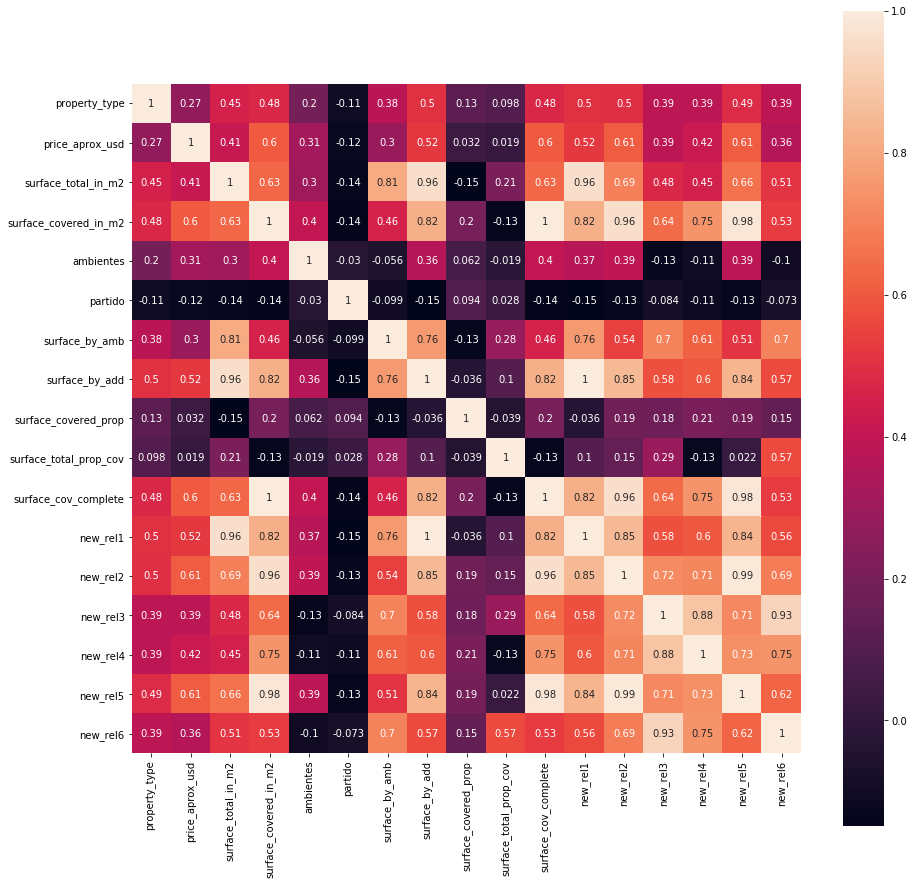

In [46]:
fig, ax = plt.subplots(figsize=(15,15))       
sns.heatmap(df.corr() , square=True, annot=True, ax=ax);

##### En la matriz observamos que los valores con mayor valor para precio son:
    * new_rel2.61
    * new_rel5 =.61
    * surface_cov_in_m2 = .60
##### Vamos a entrenar un modelo utilizando new_rel2 y new_rel5

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning:

invalid value encountered in reduce

/opt/conda/lib/python3.6/site-packages/numpy/linalg/linalg.py:1876: RuntimeWarning:

invalid value encountered in greater



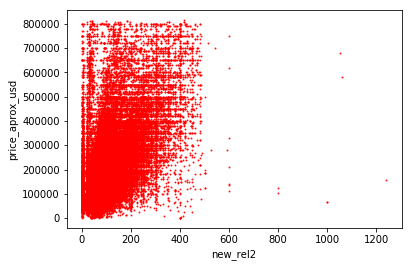

In [10]:
#reviso relación entre new_rel2 y price_aprox_usd
sns.regplot(df.new_rel2,df.price_aprox_usd, order=1, ci=None, scatter_kws={'color':'r', 's':1})
# ಠ ʖ̯ ͡ಠ

#### Creamos y almacenamos dataset de train y test
Analizamos valores en new_rel2 y new_rel5

In [47]:
df.describe()

,property_type,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,ambientes,partido,surface_by_amb,surface_by_add,surface_covered_prop,surface_total_prop_cov,surface_cov_complete,new_rel1,new_rel2,new_rel3,new_rel4,new_rel5,new_rel6
count,70779.000000,70779.000000,70779.000000,70779.000000,70779.000000,70779.000000,70779.000000,70779.000000,7.077800e+04,7.077800e+04,70779.000000,70779.000000,7.077800e+04,7.077800e+04,70779.000000,7.077800e+04,7.077800e+04
mean,1.244366,189294.475022,130.879125,89.827943,3.208466,106.375945,42.351036,220.707068,inf,inf,89.827943,223.915534,inf,inf,29.437607,inf,inf
std,0.561983,141711.520153,164.309526,80.186458,1.552800,119.843960,57.541111,223.876610,NaN,NaN,80.186458,224.446881,NaN,NaN,28.083610,NaN,NaN
min,0.000000,1000.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,2.000000,1.000000e+00,1.428571e-01,0.000000,1.000000e+00,4.000000e-01
25%,1.000000,90000.000000,45.000000,40.000000,2.000000,14.000000,17.760554,87.000000,7.223250e-01,1.000000e+00,40.000000,89.000000,4.239024e+01,1.668707e+01,15.750000,4.069221e+01,1.817647e+01
50%,1.000000,140000.000000,73.512268,63.000000,3.000000,50.000000,26.666667,139.538201,8.729833e-01,1.145497e+00,63.000000,142.000000,6.600758e+01,2.353036e+01,22.500000,6.433333e+01,2.487786e+01
75%,2.000000,240000.000000,152.906751,119.000000,4.000000,154.000000,45.000000,276.320965,1.000000e+00,1.384418e+00,119.000000,281.000000,1.211667e+02,3.600000e+01,34.750000,1.200312e+02,3.801304e+01
max,3.000000,815000.000000,1490.000000,485.000000,72.000000,538.000000,1354.000000,1916.000000,inf,inf,485.000000,1921.000000,inf,inf,480.000000,inf,inf


In [48]:
# Por alguna razon existen valores infinitos: Los eliminamos
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["new_rel2","new_rel5"], how="all")
print("Cantidad de registros:",len(df))
df.describe()

Cantidad de registros: 70771


,property_type,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,ambientes,partido,surface_by_amb,surface_by_add,surface_covered_prop,surface_total_prop_cov,surface_cov_complete,new_rel1,new_rel2,new_rel3,new_rel4,new_rel5,new_rel6
count,70771.000000,70771.000000,70771.000000,70771.000000,70771.000000,70771.000000,70771.000000,70771.000000,70665.000000,70771.000000,70771.000000,70771.000000,70771.000000,70771.000000,70771.000000,70771.000000,70771.000000
mean,1.244394,189303.113529,130.888352,89.838098,3.208546,106.369431,42.353669,220.726450,3.356698,4.156468,89.838098,223.934996,93.994565,31.233980,29.440935,91.631142,33.597402
std,0.562009,141717.007156,164.316331,80.185302,1.552861,119.849085,57.543767,223.881703,14.577685,22.736329,80.185302,224.451959,80.383922,30.375350,28.083453,79.981476,33.846498
min,0.000000,1000.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000806,0.000000,1.000000,2.000000,1.000000,0.142857,0.090909,1.000000,0.400000
25%,1.000000,90000.000000,45.000000,40.000000,2.000000,14.000000,17.760554,87.000000,0.722325,1.000000,40.000000,89.000000,42.387331,16.687075,15.750000,40.690407,18.176471
50%,1.000000,140000.000000,73.559193,63.000000,3.000000,50.000000,26.666667,139.583058,0.872727,1.145455,63.000000,142.000000,66.000000,23.523810,22.500000,64.333333,24.877209
75%,2.000000,240000.000000,152.906751,119.000000,4.000000,154.000000,45.000000,276.498431,1.000000,1.384418,119.000000,281.000000,121.166667,36.000000,34.750000,120.008333,38.000000
max,3.000000,815000.000000,1490.000000,485.000000,72.000000,538.000000,1354.000000,1916.000000,480.000000,1240.000000,485.000000,1921.000000,1241.000000,1241.000000,480.000000,1241.000000,1241.000000


### Create train and test dataset
Creamos un dataframe de test y train: Almacenamos df_test y continuamos trabajando con df_train

In [49]:
# Create train and test dataset
msk = np.random.rand(len(df)) < 0.75
df_train = df[msk]
df_test = df[~msk]
print("Cantidad registros train: ",len(df_train))
print("Cantidad registros test: ",len(df_test))

Cantidad registros train:  53156
Cantidad registros test:  17615


In [244]:
#<<Checkpoint: train_test_data>>: guardo resultados en feather (Instalacion:  conda install -c conda-forge feather-format)
# feather.write_dataframe(df_train, 'Data/train.feather')
# feather.write_dataframe(df_test, 'Data/test.feather')

#recargo resultados
df_train = feather.read_dataframe('Data/train.feather')
df_test = feather.read_dataframe('Data/test.feather')

df_train.sample(1)

,property_type,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,ambientes,partido,surface_by_amb,surface_by_add,surface_covered_prop,surface_total_prop_cov,surface_cov_complete,new_rel1,new_rel2,new_rel3,new_rel4,new_rel5,new_rel6
33734,1,70665.43,90.0,47.0,1.0,534.0,90.0,137.0,0.522222,1.914894,47.0,138.0,48.914894,48.914894,47.0,48.914894,48.914894


In [245]:
#  Rompo todas las columnas que no voy a utilizar
# ◔̯◔
to_drop = [
            'new_rel1', 'new_rel3', 'new_rel4', 'new_rel6', 
            'surface_by_amb','surface_by_add',
            'surface_covered_prop','surface_total_prop_cov',
            'surface_cov_complete','ambientes',
            'surface_covered_in_m2',
            'surface_total_in_m2',
#             'property_type',
] 
df_train.drop(columns=to_drop, inplace=True) #aplicar drop
df_train.sample(1)

,property_type,price_aprox_usd,partido,new_rel2,new_rel5
41954,0,133000.0,6.0,47.434783,46.478261


In [229]:
df_train.describe()

,property_type,price_aprox_usd,partido,new_rel2,new_rel5
count,53156.000000,53156.000000,53156.000000,53156.000000,53156.000000
mean,1.243792,189248.100748,106.437881,93.830535,91.456105
std,0.561414,141386.157338,119.776282,80.153288,79.779816
min,0.000000,1000.000000,0.000000,1.000000,1.000000
25%,1.000000,90000.000000,14.000000,42.444695,40.688605
50%,1.000000,140209.190000,50.000000,66.000000,64.265625
75%,2.000000,240000.000000,154.000000,121.083333,120.004167
max,3.000000,815000.000000,538.000000,1061.000000,1061.000000


In [246]:
# Elimino nulos en todas las columas
columnas_principales_train = ['price_aprox_usd','partido','new_rel2','new_rel5']
df_train = df_train.dropna(axis =0 , how = 'any', subset = columnas_principales_train)
print(df_train.shape)
# Elimino un cero de la columna price
df_train = df_train[df_train.price_aprox_usd>0]
print(df_train.shape)

(53156, 5)
(53156, 5)


#### Plot Pairwaise

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning:

invalid value encountered in true_divide

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning:

invalid value encountered in reduce



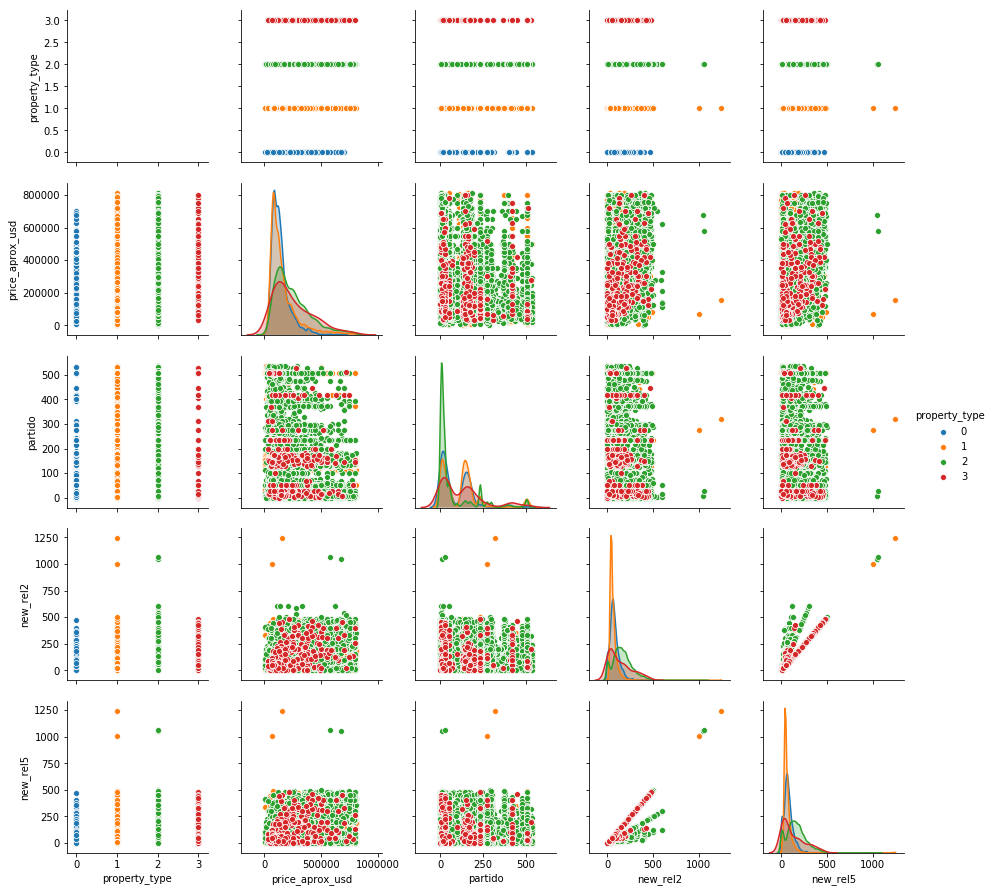

In [19]:
g = sns.pairplot(df_train, hue="property_type")

#### Crear dummies para las siguientes categoricas:
    * partido
    * property_type

In [254]:
#### *partido
df_train = pd.concat([df_train, pd.get_dummies(data = df_train['partido'], prefix= 'dum_part')], axis = 1)
#### *property_type
df_train = pd.concat([df_train, pd.get_dummies(data = df_train['property_type'], prefix= 'dum_tprop')], axis = 1)

##### Dropeamos columnas pasadas a dummies

In [255]:
to_drop = [
            'partido', 
            'property_type',
] 
df_train.drop(columns=to_drop, inplace=True) #aplicar drop
df_train.sample(1)

,price_aprox_usd,new_rel2,new_rel5,dum_part_0.0,dum_part_1.0,dum_part_2.0,dum_part_3.0,dum_part_4.0,dum_part_5.0,dum_part_6.0,...,dum_part_525.0,dum_part_528.0,dum_part_529.0,dum_part_534.0,dum_part_535.0,dum_part_538.0,dum_tprop_0,dum_tprop_1,dum_tprop_2,dum_tprop_3
27260,610000.0,203.5,201.166667,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Probamos score de modelos de regresion lineal combinando nuestras variables
***Pruebo score del modelo con las siguientes combinaciones:***
    * new_rel2, property_type y partido
    * new_rel5, property_type y partido
    * new_rel2, new_rel5, property_type y partido

A continuación no se muestran todos los resultados, pero al final se puede ver el score para cada test realizado:

In [256]:
#Test1: Solo new_rel2
X = df_train.drop(['price_aprox_usd','new_rel5'], axis = 1)
#Test2: Solo new_rel5
# X = df_train.drop(['price_aprox_usd','new_rel2'], axis = 1)
#Test3: new_rel2 y new_rel5
# X = df_train.drop(['price_aprox_usd'], axis = 1)
y = df_train['price_aprox_usd']

# Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
X.sample(2)

,new_rel2,dum_part_0.0,dum_part_1.0,dum_part_2.0,dum_part_3.0,dum_part_4.0,dum_part_5.0,dum_part_6.0,dum_part_7.0,dum_part_8.0,...,dum_part_525.0,dum_part_528.0,dum_part_529.0,dum_part_534.0,dum_part_535.0,dum_part_538.0,dum_tprop_0,dum_tprop_1,dum_tprop_2,dum_tprop_3
38495,91.066667,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1098,66.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


#### Regresion linear: Aplico training sobre las variables seleccionadas

In [234]:
lm = LinearRegression()

model = lm.fit(X_train, y_train)
predictions = lm.predict(X_train)
model_score = model.score(X_test, y_test)
print('Model Score:',model_score)

Model Score: 0.5368434879610611


##### Resultado:
Todas las pruebas se hacen probando con **dummies** en **property_types** y **partido**
 * score con **new_rel2**: 0.5368434879610611
 * score con **new_rel5**: 0.5344155375650685
 * score con **new_rel2** y **new_rel5**: 0.5304537942097489
 
 ***Conclusión: Como el mejor score lo obtuvimos new_rel2 seguimos con esta variable (new_rel2 y new_rel5 juntas no son considerablemente mejores)***
 

In [79]:
#### Divido variable independiente price de x
price=df_train.price_aprox_usd
x = df_train.drop(columns=['price_aprox_usd'])
info = df_train.drop(columns=['price_aprox_usd'])

In [81]:
x.describe()

,new_rel2,new_rel5,dum_part_0.0,dum_part_1.0,dum_part_2.0,dum_part_3.0,dum_part_4.0,dum_part_5.0,dum_part_6.0,dum_part_7.0,...,dum_part_525.0,dum_part_528.0,dum_part_529.0,dum_part_534.0,dum_part_535.0,dum_part_538.0,dum_tprop_0,dum_tprop_1,dum_tprop_2,dum_tprop_3
count,53156.000000,53156.000000,53156.000000,53156.000000,53156.000000,53156.000000,53156.000000,53156.000000,53156.000000,53156.000000,...,53156.000000,53156.000000,53156.000000,53156.000000,53156.000000,53156.000000,53156.000000,53156.000000,53156.000000,53156.000000
mean,93.830535,91.456105,0.015332,0.017627,0.001336,0.003537,0.024212,0.010385,0.027391,0.012285,...,0.000113,0.000207,0.000038,0.001185,0.000038,0.000169,0.060633,0.639721,0.294868,0.004778
std,80.153288,79.779816,0.122872,0.131594,0.036523,0.059366,0.153707,0.101375,0.163222,0.110154,...,0.010624,0.014384,0.006134,0.034407,0.006134,0.013011,0.238658,0.480086,0.455988,0.068961
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.444695,40.688605,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,66.000000,64.265625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,121.083333,120.004167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1061.000000,1061.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Analisis de model score agrupando por Partido
Los pasos que vamos a realizar son los siguientes:
* Obtener df_train original
* Eliminar columnas que no utilizamos, nulos y precios en cero
* Evaluamos algunos casos, para ello vamos a elegir los partidos que mas registros tienen
* Con la columna new_rel2 evaluamos el model score sobre cada partido seleccionado

###### En la siguiente ejecucion se obtiene el dataset de train inicial, se eliminan columnas y valores en nulo o cero

In [2]:
#<<Checkpoint: train_test_data>>: cargo resultados en feather (Instalacion:  conda install -c conda-forge feather-format)
#load training dataset
def reset_train_data():
    df_train = feather.read_dataframe('Data/train.feather')
    #  Rompo todas las columnas que no voy a utilizar
    to_drop = [
                'new_rel1', 'new_rel3', 'new_rel4', 'new_rel6', 
                'surface_by_amb','surface_by_add',
                'surface_covered_prop','surface_total_prop_cov',
                'surface_cov_complete','ambientes',
                'surface_covered_in_m2',
                'surface_total_in_m2',
    #             'property_type',
    ] 
    df_train.drop(columns=to_drop, inplace=True) #aplicar drop
    # Elimino nulos en todas las columas
    columnas_principales_train = ['price_aprox_usd','partido','new_rel2','new_rel5']
    df_train = df_train.dropna(axis =0 , how = 'any', subset = columnas_principales_train)
    # Elimino un cero de la columna price
    df_train = df_train[df_train.price_aprox_usd>0]
    return df_train

df_train = reset_train_data()
print(df_train.shape)
df_train.sample(1)

(53156, 5)


,property_type,price_aprox_usd,partido,new_rel2,new_rel5
47114,2,345000.0,59.0,235.106838,234.553419


###### Reviso que partidos tienen mayor cantidad de datos para realizar un training por partido
* Vamos a evaluar las 6 localidades con mas registros

In [196]:
df_train['partido'].value_counts(ascending=False).head(6)

50.0     4484
8.0      4264
234.0    3016
9.0      2111
154.0    1947
506.0    1810
Name: partido, dtype: int64

****(Opcional)Recupero algunos partidos para saber a que hacen referencia****
* Vamos a evaluar las 6 localidades con mas registros

In [113]:
df_partidos = feather.read_dataframe('Data/partidos.feather')
print(" 50 es: ",df_partidos.iloc[50].nombre)
print("  8 es: ",df_partidos.iloc[8].nombre)
print("234 es: ",df_partidos.iloc[234].nombre)


 50 es:  mar del plata
  8 es:  tigre
234 es:  córdoba


****Funcion para generar dummies dado un dataset y un column_name****
* Se elimina la columna original

In [3]:
def dummies_creator(df_in,column_name):
    prefix_name="dum_"+column_name
    df_in = pd.concat([df_in, pd.get_dummies(data = df_in[column_name], prefix= prefix_name)], axis = 1)
    # Elimino la columna utilizada
    to_drop = [column_name] 
    df_in.drop(columns=to_drop, inplace=True) #aplicar drop
    return df_in

****Funcion para dividir datos por una columna y un valor especifico****
* Se elimina la columna mediante la cual se fragmentaron los datos

In [4]:
def chunk_df_by_column(df_in,column_name,column_value):
    df_chunked = df_in[df_in[column_name] == column_value]
    print(column_name,"=>", column_value,"- cantidad de registros:", len(df_chunked))
    to_drop = [column_name] 
    df_chunked.drop(columns=to_drop, inplace=True) #aplicar drop
    return df_chunked

#testeo  las funciones
# df_train_50 = chunk_df_by_column(df_train,"partido",50)
# # Generamos Dummies para:
# # #### *property_type
# df_train_50 = dummies_creator(df_train_50,"property_type")
# df_train_50.sample(1)

****Funcion que evalua el model score de df_train****
* Tiene hardcodeados las columnas que se deben eliminar para generer X e y

In [70]:
def lreg_score(df_in):
    X = df_in.drop(['price_aprox_usd','new_rel5'], axis = 1)
    y = df_in['price_aprox_usd']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
    lm = LinearRegression()
    model = lm.fit(X_train, y_train)
    predictions = lm.predict(X_train)
    model_score = model.score(X_test, y_test)
    print('Model Score:',model_score)
    return model
    
# lreg_score(df_train_50)

****En la siguiente ejecucion se itera un conjunto de partidos y se evalua su model score****
* Se utilizan las funciones anteriormente mencionadas para ejecutar este paso
***

In [6]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

array_partidos = [50,8,234,9,154,506]
for val in array_partidos:
    printmd("<span style='color:blue'>Evaluando Regresion en partido: "+str(val)+"</span>")
    df_train_aux = chunk_df_by_column(df_train,"partido",val)
    df_train_aux = dummies_creator(df_train_aux,"property_type")
    lreg_score(df_train_aux)

<span style='color:blue'>Evaluando Regresion en partido: 50</span>

partido => 50 - cantidad de registros: 4484
Model Score: 0.47483386298994823


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



<span style='color:blue'>Evaluando Regresion en partido: 8</span>

partido => 8 - cantidad de registros: 4264
Model Score: 0.5977259672067188


<span style='color:blue'>Evaluando Regresion en partido: 234</span>

partido => 234 - cantidad de registros: 3016
Model Score: 0.2985351234401761


<span style='color:blue'>Evaluando Regresion en partido: 9</span>

partido => 9 - cantidad de registros: 2111
Model Score: 0.5204222429372234


<span style='color:blue'>Evaluando Regresion en partido: 154</span>

partido => 154 - cantidad de registros: 1947
Model Score: 0.4362105909677873


<span style='color:blue'>Evaluando Regresion en partido: 506</span>

partido => 506 - cantidad de registros: 1810
Model Score: 0.3689523819631578


| <span style='color:brown;font-weight:bold;aling:center;font-size:15px'>Resultado</span> |    |
|------|------|
| !!!  |<span style='color:crimson;font-size:13px'>De dividir por partido no se obtiene una mejora significativa, si bien en algunos partidos puede dar un resultado mejor</span>|

### Analisis de model score agrupando por property_type
Los pasos que vamos a realizar son los siguientes:
* Obtener df_train original
* Eliminar columnas que no utilizamos, nulos y precios en cero
* Con la columna new_rel2 evaluamos el model score sobre cada partido seleccionado

#### Reseteo df_train

In [170]:
#load training dataset
df_train = reset_train_data()
print(df_train.shape)
df_train.sample(1)

(53156, 5)
(53156, 5)


,property_type,price_aprox_usd,partido,new_rel2,new_rel5
39834,2,80000.0,13.0,101.998839,100.99942


In [174]:
df_train.property_type.unique()

array([0, 1, 2, 3])

 **Vamos a realizar las acciones de agrupamiento y evaluacion reutilizando las funciones de los pasos anteriores**
 
     - property_type

In [178]:
df_train_aux = chunk_df_by_column(df_train,"property_type",0)
df_train_aux = dummies_creator(df_train_aux,"partido")
df_train_aux.sample(1)

property_type => 0 - cantidad de registros: 3223


,price_aprox_usd,new_rel2,new_rel5,dum_partido_0.0,dum_partido_1.0,dum_partido_2.0,dum_partido_3.0,dum_partido_4.0,dum_partido_5.0,dum_partido_6.0,...,dum_partido_405.0,dum_partido_406.0,dum_partido_408.0,dum_partido_415.0,dum_partido_418.0,dum_partido_445.0,dum_partido_505.0,dum_partido_506.0,dum_partido_514.0,dum_partido_534.0
48663,97000.0,43.268262,42.317065,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [179]:
array_property_types = [0, 1, 2, 3]
for val in array_property_types:
    printmd("<span style='color:blue'>Evaluando Regresion en property_type: "+str(val)+"</span>")
    df_train_aux = chunk_df_by_column(df_train,"property_type",val)
    df_train_aux = dummies_creator(df_train_aux,"partido")
    lreg_score(df_train_aux)

<span style='color:blue'>Evaluando Regresion en property_type: 0</span>

property_type => 0 - cantidad de registros: 3223
Model Score: -1.2675649553059269e+17


<span style='color:blue'>Evaluando Regresion en property_type: 1</span>

property_type => 1 - cantidad de registros: 34005
Model Score: -1599742595701422.5


<span style='color:blue'>Evaluando Regresion en property_type: 2</span>

property_type => 2 - cantidad de registros: 15674
Model Score: -4680843721216245.0


<span style='color:blue'>Evaluando Regresion en property_type: 3</span>

property_type => 3 - cantidad de registros: 254
Model Score: -8.208343339040609e+19


| <span style='color:brown;font-weight:bold;aling:center;font-size:15px'>Resultado</span> |    |
|------|------|
| !!!  |<span style='color:crimson;font-size:13px'>Los resultados obtenidos no mejoran el puntaje del modelo</span>|

### Analisis de model score agrupando por provincia
Los pasos que vamos a realizar son los siguientes:
* Reset de df_train
* Reincorporo la columna provincias
* Con la columna new_rel2 evaluamos el model score sobre cada provincia seleccionada

#### Reseteo df_train

In [8]:
#load training dataset
df_train = reset_train_data()
print(df_train.shape)
df_train.sample(1)

(53156, 5)


,property_type,price_aprox_usd,partido,new_rel2,new_rel5
1509,2,103000.0,13.0,4.0,3.333333


#### Reincorporo la columna provincia

In [195]:
### Cargar dataset inicial
df_principal = feather.read_dataframe("Data/principal.feather")
df_principal.sample(1)
df_principal_provincias = df_principal.provincia
df_train = df_train.merge(pd.DataFrame(df_principal_provincias), left_index=True, right_index=True)
columnas_principales_train = ['price_aprox_usd','partido','new_rel2','new_rel5','provincia']
print("cant_reg antes: ",len(df_train))
df_train = df_train.dropna(axis =0 , how = 'any', subset = columnas_principales_train)
print("cant_reg luego: ",len(df_train))
df_train.sample(2)

cant_reg antes:  53156
cant_reg luego:  53156


,property_type,price_aprox_usd,partido,new_rel2,new_rel5,provincia
50167,1,295000.0,133.0,141.000000,140.200000,0.0
7425,1,91000.0,144.0,42.146341,41.573171,2.0


#### Reviso que partido tiene mayor cantidad de datos para realizar un training por provincia

In [197]:
df_train['provincia'].value_counts(ascending=False).head(6)

5.0     14018
0.0     12134
3.0      6396
1.0      5823
24.0     3989
2.0      3784
Name: provincia, dtype: int64

****(Opcional)Recupero algunas provincias para saber a que hacen referencia****

In [199]:
df_provincias = feather.read_dataframe('Data/provincias.feather')
print("5 es: ",df_provincias.iloc[5].nombre)
print("0 es: ",df_provincias.iloc[0].nombre)
print("3 es: ",df_provincias.iloc[3].nombre)
print("1 es: ",df_provincias.iloc[1].nombre)

5 es:  capital federal
0 es:  bs.as. g.b.a. zona norte
3 es:  buenos aires costa atlántica
1 es:  bs.as. g.b.a. zona oeste


****En la siguiente ejecucion se itera un conjunto de provincias y se evalua su model score****
* Se utilizan las funciones anteriormente mencionadas para ejecutar este paso

In [202]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

array_provincias = [5,0,3,1,24,2]
for val in array_provincias:
    printmd("<span style='color:blue'>Evaluando Regresion en provincia: "+str(val)+"</span>")
    df_train_aux = chunk_df_by_column(df_train,"provincia",val)
    df_train_aux = dummies_creator(df_train_aux,"partido")
    df_train_aux = dummies_creator(df_train_aux,"property_type")
    lreg_score(df_train_aux)

<span style='color:blue'>Evaluando Regresion en provincia: 5</span>

provincia => 5 - cantidad de registros: 14018
Model Score: -254279756823236.1


<span style='color:blue'>Evaluando Regresion en provincia: 0</span>

provincia => 0 - cantidad de registros: 12134
Model Score: -4500925259866578.0


<span style='color:blue'>Evaluando Regresion en provincia: 3</span>

provincia => 3 - cantidad de registros: 6396
Model Score: -4399173637111825.5


<span style='color:blue'>Evaluando Regresion en provincia: 1</span>

provincia => 1 - cantidad de registros: 5823
Model Score: -163734667146396.12


<span style='color:blue'>Evaluando Regresion en provincia: 24</span>

provincia => 24 - cantidad de registros: 3989
Model Score: -28826580150279.77


<span style='color:blue'>Evaluando Regresion en provincia: 2</span>

provincia => 2 - cantidad de registros: 3784
Model Score: -179526209848384.8


| <span style='color:brown;font-weight:bold;aling:center;font-size:15px'>Resultado</span> |    |
|------|------|
| !!!  |<span style='color:crimson;font-size:13px'>Los resultados obtenidos no mejoran el puntaje del modelo</span>|

## Modelanding

##### Reseteo df_train

In [7]:
#load training dataset
df_train = reset_train_data()
print(df_train.shape)
df_train.sample(1)

(53156, 5)


,property_type,price_aprox_usd,partido,new_rel2,new_rel5
18405,2,230000.0,8.0,91.0,90.333333


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



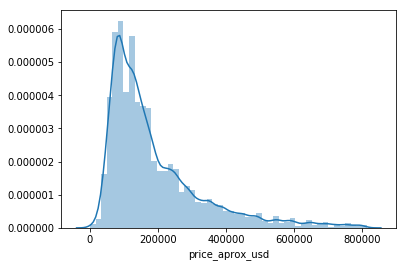

In [11]:
sns.distplot(df_train['price_aprox_usd'])

#### Reincorporo provincia

In [341]:
### Cargar dataset inicial
# df_principal = feather.read_dataframe("Data/principal.feather")
# df_principal.sample(1)
# df_principal_provincias = df_principal.provincia
# df_train = df_train.merge(pd.DataFrame(df_principal_provincias), left_index=True, right_index=True)
# columnas_principales_train = ['price_aprox_usd','partido','new_rel2','new_rel5','provincia']
# df_train = df_train.dropna(axis =0 , how = 'any', subset = columnas_principales_train)
# print("cant_reg luego: ",len(df_train))
# df_train.sample(1)

cant_reg luego:  53156


,property_type,price_aprox_usd,partido,new_rel2,new_rel5,provincia
27670,1,124672.0,168.0,47.108696,46.554348,10.0


#### Verificar este paso --------------------------DIVIDIR EN CAPITAL----------------------------------------------------------

In [345]:
# Recuperar provincias y realizar chunk solo para capital federal
#### Solo evaluaremos para capital federal [5]:
# df_train = chunk_df_by_column(df_train,"provincia",5)
# print(len(df_train))
# df_train.sample(1)

#### Genero dummies y datos de train y test
- Se genera X_train, X_test, y_train, y_test

In [8]:
#### *partido dummies
df_train = dummies_creator(df_train,"partido")
#### *property_type dummies
df_train = dummies_creator(df_train,"property_type")
### Cargar
X = df_train.drop(['price_aprox_usd','new_rel5'], axis = 1)
y = df_train['price_aprox_usd']
# Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
print("X_train count:",len(X_train),"X_test count:",len(X_test))

X_train count: 39867 X_test count: 13289


#### Vuelvo a probar Linear Reggression simple para verificar que los datos esten ok

In [14]:
def lreg_simple_score(X_train, X_test, y_train, y_test):
    lm = LinearRegression()
    model = lm.fit(X_train, y_train)
#     predictions = lm.predict(X_train)
    model_score = model.score(X_test, y_test)
    print('Model Score:',model_score)
    return model
    
model_regl = lreg_simple_score(X_train, X_test, y_train, y_test)

Model Score: 0.5368434879610611


#### Regresion Ridge (Sin normalizar features)

In [15]:
#definimos CV con un random antes de hacer cada particion
CVL = KFold(n_splits=5, shuffle=True)
def lreg_ridgecv_score(X_train, X_test, y_train, y_test, alfas_ridge):
    lm_ridge =  RidgeCV(alphas= alfas_ridge, cv=CVL, normalize=False, fit_intercept = True)
    model_ridge = lm_ridge.fit(X_train, y_train)
#     predictions_ridge = lm_ridge.predict(X_train)
    model_score_ridge = model_ridge.score(X_test, y_test)
    print('Model Score(RidgeCV):', model_score_ridge)
    print('Best alpha (RidgeCV):', model_ridge.alpha_)
    return model_ridge

# alfas_ridge = np.linspace(0.8, 1.2, 10)
alfas_ridge = [1.0083]
model_ridge_cv = lreg_ridgecv_score(X_train, X_test, y_train, y_test, alfas_ridge)

Model Score(RidgeCV): 0.5375864840760587
Best alpha (RidgeCV): 1.0083


#### Evalúo con Elastic Net. Para ello debo tener normalizadas las features

### Elastic Net
***La siguiente funcion lreg_elastic_score permite obtener un model con elastic net e imprimir su score***

In [49]:
def lreg_elastic_score(X_train, X_test, y_train, y_test):
    lm_elastic =  ElasticNetCV(l1_ratio= [.1, .5, .7, .9, .95, .99, 1],cv = 5)
    model_elastic = lm_elastic.fit(X_train, y_train)
    predictions_en = lm_elastic.predict(X_train)
    model_score_elastic = model_elastic.score(X_test, y_test)
    print('Model Score(Elastic):', model_score_elastic)
    return model_elastic

In [18]:
#reviso la varianza para ver si es necesario normalizar
# print([X[col].var() for col in X.columns])

#### Normalizacion de variables en df_train

In [9]:
# Vuelvo a generar X e y
X = df_train.drop(['price_aprox_usd','new_rel5'], axis = 1)
y = df_train['price_aprox_usd']

# Normalizamos con standard scaler
std_scaler = StandardScaler()
X_norm = std_scaler.fit_transform(X)
X_mean = np.mean(X_norm[:,1])
X_std = np.std(X_norm[:,1])
print("Media: ",X_mean,"- Desvio:",X_std)

Media:  2.5664874194058852e-17 - Desvio: 1.0


In [10]:
# Volvemos a hacer split para train y test
X_train_norm, X_test_norm, y_train, y_test = train_test_split(X_norm, y, test_size=0.25, random_state=1)

In [19]:
# Utilizo funcion de elastic
lreg_elastic_score(X_train_norm, X_test_norm, y_train, y_test)

Model Score(Elastic): 0.5367928584627719


### OLS

In [11]:
import statsmodels.api as sm
df_X_norm = pd.DataFrame(X_norm, columns=X.columns)
#agrego el intercepto
X_intercept = sm.add_constant(df_X_norm)
y.index = range(y.shape[0])

# Fit and summarize OLS model (OLS = ordinary least square linear regression) Veo las descritivas del modelo
model_intercept = sm.OLS(y, X_intercept)
model_intercept = model_intercept.fit()
print (model_intercept.summary())
predictions_intercept = model_intercept.predict(X_intercept)

                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     169.1
Date:                Fri, 12 Jul 2019   Prob (F-statistic):               0.00
Time:                        00:32:07   Log-Likelihood:            -6.8523e+05
No. Observations:               53156   AIC:                         1.371e+06
Df Residuals:                   52790   BIC:                         1.374e+06
Df Model:                         365                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.892e+05    

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



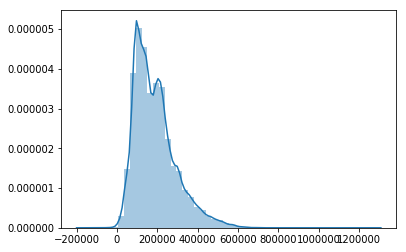

In [23]:
sns.distplot(predictions_intercept)

### Calculo de residuos

In [20]:
predictions_intercept_df = pd.DataFrame(predictions_intercept, columns=['price_aprox_usd'])
residuos_intercept = y - predictions_intercept
print(residuos_intercept.mean())

69.71715083903992


#### Verifico la distribución y que la media de los residuos sea cero

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



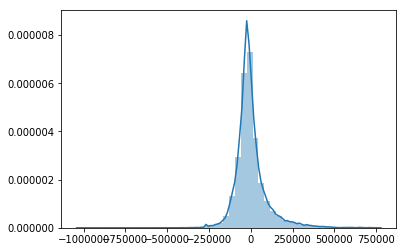

In [21]:
sns.distplot(residuos_intercept)

#### Algun comentario ?
* Intento de descripcion breve

#### Verificar homeosticidad
* verifico homocedasticidad con base en p_value
* supuesto: Para cualquier valor de la variable explicativa, el error tienen la misma varianza

In [33]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

resids_standardized = model_intercept.get_influence().resid_studentized_internal
resids = model_intercept.resid

###Breush-Pagan test###
data_bptest=sms.het_breuschpagan(resids, model_intercept.model.exog)
name = ['Lagrange multiplier statistic', 'p-value',
            'f-value', 'f p-value']
result_bp = lzip(name,data_bptest)

###Breush-Pagan test###
name = ['F statistic', 'p-value']
data_gqtest=sms.het_goldfeldquandt(resids, model_intercept.model.exog)[:-1]
result_gq = lzip(name,data_gqtest)

print('\n Breusch-Pagan test ----')
print(result_bp)
print('\n Goldfeld-Quandt test ----')
print(result_gq)

/opt/conda/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:323: RuntimeWarning:

invalid value encountered in sqrt

/opt/conda/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:323: RuntimeWarning:

divide by zero encountered in true_divide




 Breusch-Pagan test ----
[('Lagrange multiplier statistic', 4747.190286937108), ('p-value', 0.0), ('f-value', 14.183095712730996), ('f p-value', 0.0)]

 Goldfeld-Quandt test ----
[('F statistic', 0.7734291246494478), ('p-value', 0.9999999999999999)]


| <span style='color:brown;font-weight:bold;aling:center;font-size:15px'>Resultado</span> |    |
|------|------|
| !!!  |<span style='color:crimson;font-size:13px'>Es inconsistente: los dos test dan distintos resultados</span>|

#### Vemos los gráficos de los residuos, no obtengo una linea horizontal (supuesto de homocedasticidad)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning:

invalid value encountered in sqrt



[Text(0, 0.5, 'sqrt(abs(Residuals))'), Text(0.5, 0, 'Fitted Values')]

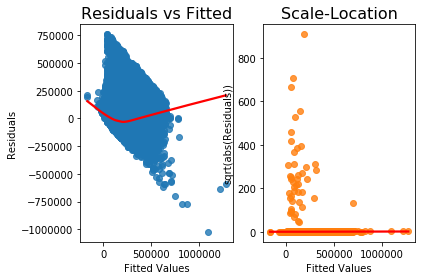

In [36]:
###################################################### !!Tarda Narda
fig, ax = plt.subplots(1,2)

fitted_vals = predictions_intercept

sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Residuals vs Fitted', fontsize=16)
ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Scale-Location', fontsize=16)
ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

#### Verifico si los residuos tienen distribucion normal. 
* Con un grafico de datos reales vs simulados (Deberia dar una recta)
* El grafico es en quantiles

/opt/conda/lib/python3.6/site-packages/scipy/stats/morestats.py:1309: UserWarning:

p-value may not be accurate for N > 5000.



Jarque-Bera test ---- statistic: 160715.4250, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.8608, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.6117, p-value: 0.0000
Anderson-Darling test ---- statistic: 1907.3168, 5% critical value: 0.7870
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected.


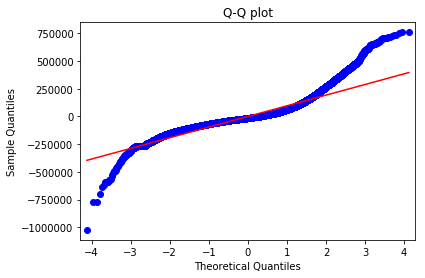

In [37]:
sm.ProbPlot(model_intercept.resid).qqplot(line='s');
plt.title('Q-Q plot');

jb = stats.jarque_bera(model_intercept.resid)
sw = stats.shapiro(model_intercept.resid)
ad = stats.anderson(model_intercept.resid, dist='norm')
ks = stats.kstest(model_intercept.resid, 'norm')

print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected.')

#### Verifico el R2 y el error de la regresión

In [39]:
print('r2: ' + str(model_intercept.rsquared))

r2: 0.5390091687092211


#### Calculamos el RMSE
* Recordemos nuestros datos son ***X_train_norm, X_test_norm, y_train, y_test***

In [45]:
def calculate_rmse(model, X_train, y_train, y):
    y_pred_tr_lm = model.predict(X_train)
    #definimos la raiz del error cuadratico medio
    rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))
    print("Score Test Lineal: %.2f\n" % model.score(X_train, y_train))
    print(" Train RMSE lineal   : %.2f \n" % rmse(y_train,y_pred_tr_lm))

In [50]:
# testeamos #tarda (2min)
model_elastic = lreg_elastic_score(X_train_norm, X_test_norm, y_train, y_test)
calculate_rmse(model_elastic,X_train_norm,y_train,y)

Model Score(Elastic): 0.5367928584627719
Score Test Lineal: 0.54

 Train RMSE lineal   : 96005.77 



### Ridge

In [61]:
#los alfas se crean para hacer un tunning de los hiperparámetros de los modelos en base a validación cruzada
#despues creo la regresion y le paso el alfa que obtuve
kf = KFold(n_splits=5, shuffle=True)
alfas_ridge = np.linspace(200, 1000, 5)
lm_ridge_cv= RidgeCV(alphas=alfas_ridge, cv=kf, normalize=False, fit_intercept = True)
lm_ridge_cv.fit(X_train_norm, y_train)
print('Alpha Ridge:', lm_ridge_cv.alpha_)   

#utilizo el alfa del paso anterior y  fiteo con un intercepto
model_ridge = Ridge(lm_ridge_cv.alpha_, normalize=False, fit_intercept = True)
model_ridge.fit(X_train_norm, y_train)

y_pred_ridge = model_ridge.predict(X_train_norm)
np.sqrt(mean_squared_error(y_train, y_pred_ridge))

Alpha Ridge: 600.0


95999.22858686905

### Lasso

In [66]:
#pruebo lo mismo que en el paso anterior pero con lasso para verificar consistencia y encontrar el mejor modelo
alfas_lasso = np.linspace(1, 5, 3)
lm_lasso_cv = LassoCV(alphas=alfas_lasso, cv=kf, normalize=False, fit_intercept = True)
lm_lasso_cv.fit(X_train, y_train)
print('Alpha LASSO:', lm_lasso_cv.alpha_)

model_lasso = Lasso(lm_lasso_cv.alpha_, normalize=False, fit_intercept = True)
model_lasso.fit(X_train, y_train)
y_pred_lasso = model_lasso.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred_lasso))

Alpha LASSO: 3.0


96113.70263128387

#### Calculamos el R2 para ridge y Lasso

In [67]:
# Calculamos el R2 para ridge y Lasso
print("Score Train Ridge : %.2f\n" % lm_ridge_cv.score(X_train_norm, y_train),
      "Score Train Lasso : %.2f\n" %  lm_lasso_cv.score(X_train_norm, y_train))

# Calculamos el RMSE
rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

print(
#         " Train RMSE lineal   : %.2f \n" % rmse(y_train,y_pred_lm),
        "Train RMSE Ridge    : %.2f \n" % rmse(y_train,y_pred_ridge),
        "Train RMSE Lasso    : %.2f \n" % rmse(y_train,y_pred_lasso))

Score Train Ridge : 0.54
 Score Train Lasso : -89.17

Train RMSE Ridge    : 95999.23 
 Train RMSE Lasso    : 96113.70 



### Linear Regression
* Hacemos el calculo con los datos de test (score y error cuadratico medio)

***Redefino calculo de LinearRegression***

In [72]:
def lreg_score_splitted(X_train, X_test, y_train, y_test):
    lm = LinearRegression()
    model = lm.fit(X_train, y_train)
    predictions = lm.predict(X_train)
    model_score = model.score(X_test, y_test)
    print('Model Score:',model_score)
    return model

* Evaluando con modelo linear

In [73]:
lm = lreg_score_splitted(X_train, X_test, y_train, y_test)
lm.fit(X_test, y_test)

y_pred_lmtest = lm.predict(X_test)
print(" Score Test Lineal: %.2f\n" % lm.score(X_test, y_test))
print(" Test RMSE lineal= %.2f\n" % rmse(y_test, y_pred_lmtest))

Model Score: 0.5368434879610611
 Score Test Lineal: 0.55

 Test RMSE lineal= 95166.63



#### Pruebo con test ridge

In [74]:
lm_ridge_cv.fit(X_test_norm, y_test)
print('Alpha Ridge:', lm_ridge_cv.alpha_) 

y_pred_ridgetest = model_ridge.predict(X_test_norm)

np.sqrt(mean_squared_error(y_test, y_pred_ridgetest))

Alpha Ridge: 400.0


96652.46121799429

#### Pruebo con test lasso

In [75]:
model_lasso.fit(X_test_norm, y_test)
y_pred_lassotest = model_lasso.predict(X_test_norm)
np.sqrt(mean_squared_error(y_test, y_pred_lassotest))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



95166.64217702998

#### Valores para test

In [76]:
print("Score Test Ridge : %.2f\n" % lm_ridge_cv.score(X_test_norm, y_test),
      "Score Test Lasso : %.2f\n" %  lm_lasso_cv.score(X_test_norm, y_test))

print("Test RMSE Ridge = %.2f\n" %  rmse(y_test, y_pred_ridgetest),
      "Test RMSE Lasso = %.2f" %  rmse(y_test, y_pred_lassotest))

Score Test Ridge : 0.55
 Score Test Lasso : -41.58

Test RMSE Ridge = 96652.46
 Test RMSE Lasso = 95166.64


### Valores Obtenidos

* Score Test Lineal: 0.55
* Score Test Ridge : 0.55
* Score Test Lasso : -41.58 (OMG)